## X-ray image loading and analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier


from tensorflow.keras.layers import Input
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers, regularizers
from keras.callbacks import EarlyStopping

### Now that the files have been moved to their respective labels, we can use the image generator to begin modeling analysis

In [2]:
data_dir = 'Classes'


#create test generator for final model evaluation(20% of entire dataset)
test_generator = ImageDataGenerator(1./255).flow_from_directory(
       data_dir, 
       target_size=(128, 128), batch_size=1340, color_mode='grayscale', class_mode='binary')

#create train generator for model training and validation(80% of dataset). Will create validation split with TTS from train set
train_generator = ImageDataGenerator(1./255).flow_from_directory(
       data_dir, 
       target_size=(128, 128), batch_size=5360, color_mode='grayscale', class_mode='binary')

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 6700 images belonging to 2 classes.
Found 6700 images belonging to 2 classes.


C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


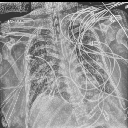

In [3]:
#sample photo
array_to_img(train_images[0])

In [4]:
#labels
train_generator.class_indices

{'deceased': 0, 'discharged': 1}

#### checking image and label shapes for model creation

In [5]:
train_images.shape

(5360, 128, 128, 1)

In [6]:
train_labels.shape

(5360,)

In [7]:
test_images.shape

(1340, 128, 128, 1)

In [8]:
test_labels.shape

(1340,)

#### Creating validation data from TTS in order to train CNN models

In [9]:
#train test split to generate training and validation data

X = train_images
y = train_labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#investigating shapes of train and validation sets
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(y_train))
print(np.shape(y_val))

(4288, 128, 128, 1)
(1072, 128, 128, 1)
(4288,)
(1072,)


In [11]:
#function to plot epochs vs loss and accuracy for train and validation/test set
def visualize_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['test_loss', 'train_loss'])
    plt.title('Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['test_acc', 'train_acc'])
    plt.title('Epochs vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show();

## Baseline dummy classifier

In [12]:
#dummy classifier to compare baseline models to


dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.predict(X_val)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [13]:
#dummy classifier score
dummy.score(X_val, y_val)

0.6007462686567164

### To start, a simple CNN model will be used with no dropouts or multiple dense layers.

In [15]:
#baseline CNN model
np.random.seed(424)
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Accuracy will be the primary metric of evaluation. A low learning rate is used to improve model learning. SGD is the preferred optimizer; previous iterations with Adam yielded lower accuracy rates.

In [17]:
#compile and fit the training data, then validate the fit with validation data
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]
optimizer = keras.optimizers.SGD(lr=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results = model.fit(X_train,
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
34/34 [==============================] - 14s 400ms/step - loss: 0.6696 - acc: 0.6101 - val_loss: 0.6820 - val_acc: 0.5896
Epoch 2/50
34/34 [==============================] - 14s 398ms/step - loss: 0.6619 - acc: 0.6168 - val_loss: 0.6805 - val_acc: 0.5896
Epoch 3/50
34/34 [==============================] - 14s 397ms/step - loss: 0.6551 - acc: 0.6192 - val_loss: 0.6784 - val_acc: 0.5886
Epoch 4/50
34/34 [==============================] - 14s 398ms/step - loss: 0.6493 - acc: 0.6234 - val_loss: 0.6777 - val_acc: 0.5905
Epoch 5/50
34/34 [==============================] - 14s 398ms/step - loss: 0.6435 - acc: 0.6264 - val_loss: 0.6762 - val_acc: 0.5933
Epoch 6/50
34/34 [==============================] - 14s 398ms/step - loss: 0.6380 - acc: 0.6292 - val_loss: 0.6750 - val_acc: 0.5942
Epoch 7/50
34/34 [==============================] - 14s 397ms/step - loss: 0.6327 - acc: 0.6334 - val_loss: 0.6735 - val_acc: 0.5942
Epoch 8/50
34/34 [==============================] - 14s 400ms/step - 

#### Model results with train and validation sets

In [18]:
results_train = model.evaluate(X_train, y_train)

134/134 [==============================] - 4s 32ms/step - loss: 0.4966 - acc: 0.7570


In [19]:
results_val = model.evaluate(X_val, y_val)

34/34 [==============================] - 1s 31ms/step - loss: 0.6629 - acc: 0.6017


#### Visualizing results

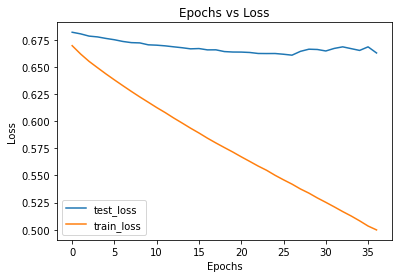

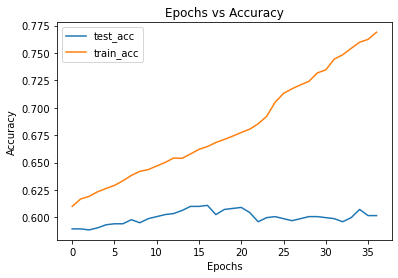

In [20]:
visualize_results(results)

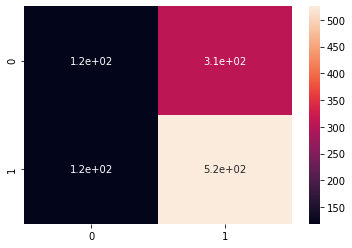

In [21]:
#confusion matrix for model predictions

label_pred = (model.predict(X_val) > 0.5).astype(int)

cf_matrix = confusion_matrix(y_val, label_pred)

sns.heatmap(cf_matrix, annot=True);

### Insight: This model appears to begin overfitting to the training data, and the validation accuracy does not increase. Will adding addtional convolution layers increase performance?

In [30]:
# Increasing convolutional layers
np.random.seed(424)
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(16, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (2, 2), activation='relu'))
model2.add(layers.MaxPooling2D((3, 3)))

model2.add(layers.Flatten())
model2.add(layers.Dense(96, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [31]:
optimizer = keras.optimizers.SGD(lr=0.00001)
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results2 = model2.fit(X_train,
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
34/34 [==============================] - 15s 435ms/step - loss: 13.8054 - acc: 0.5392 - val_loss: 3.1931 - val_acc: 0.4011
Epoch 2/50
34/34 [==============================] - 15s 433ms/step - loss: 3.5303 - acc: 0.5303 - val_loss: 6.6572 - val_acc: 0.6007
Epoch 3/50
34/34 [==============================] - 15s 434ms/step - loss: 3.3430 - acc: 0.5303 - val_loss: 0.8442 - val_acc: 0.5728
Epoch 4/50
34/34 [==============================] - 15s 434ms/step - loss: 2.5568 - acc: 0.5459 - val_loss: 1.4107 - val_acc: 0.5942
Epoch 5/50
34/34 [==============================] - 15s 432ms/step - loss: 2.2357 - acc: 0.5550 - val_loss: 1.3089 - val_acc: 0.5970
Epoch 6/50
34/34 [==============================] - 15s 432ms/step - loss: 2.1917 - acc: 0.5445 - val_loss: 2.1984 - val_acc: 0.5998
Epoch 7/50
34/34 [==============================] - 15s 432ms/step - loss: 2.0297 - acc: 0.5501 - val_loss: 0.9970 - val_acc: 0.5979
Epoch 8/50
34/34 [==============================] - 15s 431ms/step -

#### Model2 predictions and visualizing results

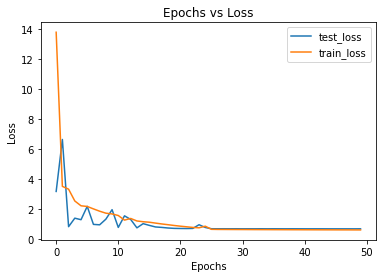

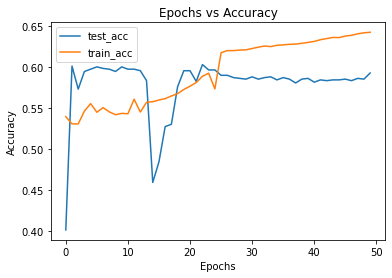

In [32]:
train_pred = (model2.predict(X_train) > 0.5).astype(int)
val_pred = (model2.predict(X_val) > 0.5).astype(int)

visualize_results(results2)

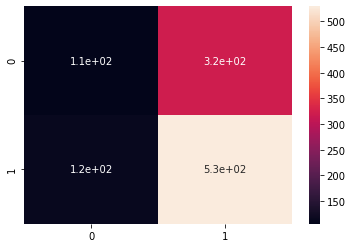

In [33]:
cf_matrix = confusion_matrix(y_val, val_pred)
sns.heatmap(cf_matrix, annot=True);

### While the 2nd model resolves the overfitting issue, the accuracy has decreased for both training and validation sets. Will regularization improve accuracy scores for better predictions? 

In [35]:
#adding regularization penalty to model

model3 = models.Sequential()
model3.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(96, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))


model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model3.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(layers.Dense(1, activation='sigmoid'))

In [36]:
optimizer = keras.optimizers.SGD(lr=0.0001)
early_stopping2 = [EarlyStopping(monitor='val_loss', patience=10)]
model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results3 = model3.fit(X_train,
                    y_train,
                    callbacks=early_stopping2,
                    epochs=25,
                    batch_size=64,
                    validation_data=(X_val, y_val), shuffle=False)

Epoch 1/25
67/67 [==============================] - 107s 2s/step - loss: 2.5719 - acc: 0.5205 - val_loss: 1.9769 - val_acc: 0.5914
Epoch 2/25
67/67 [==============================] - 107s 2s/step - loss: 1.9857 - acc: 0.5588 - val_loss: 1.9559 - val_acc: 0.5914
Epoch 3/25
67/67 [==============================] - 107s 2s/step - loss: 1.9586 - acc: 0.5770 - val_loss: 1.9491 - val_acc: 0.5821
Epoch 4/25
67/67 [==============================] - 107s 2s/step - loss: 1.9443 - acc: 0.5879 - val_loss: 1.9435 - val_acc: 0.5840
Epoch 5/25
67/67 [==============================] - 107s 2s/step - loss: 1.9347 - acc: 0.5947 - val_loss: 1.9391 - val_acc: 0.5849
Epoch 6/25
67/67 [==============================] - 107s 2s/step - loss: 1.9252 - acc: 0.6031 - val_loss: 1.9353 - val_acc: 0.5914
Epoch 7/25
67/67 [==============================] - 112s 2s/step - loss: 1.9179 - acc: 0.6056 - val_loss: 1.9327 - val_acc: 0.5924
Epoch 8/25
67/67 [==============================] - 117s 2s/step - loss: 1.9135 - a

#### Visualizing results for model 3

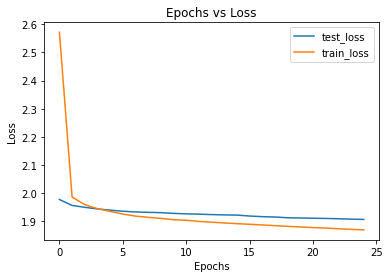

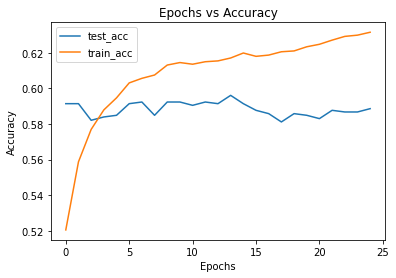

In [37]:
visualize_results(results3)

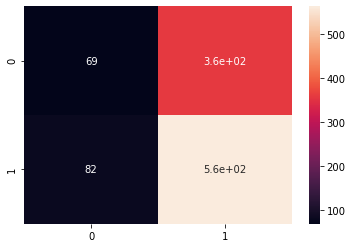

In [38]:
val_pred3 = (model3.predict(X_val) > 0.5).astype(int)
cf_matrix = confusion_matrix(y_val, val_pred3)
sns.heatmap(cf_matrix, annot=True);

### Insight: model 1 performed the best out of all the models, so it will be used to generate probability predictions for the train and test sets

In [39]:
#fit against entire train set and validate with test set, then generate predictions
np.random.seed(424)
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [40]:
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]
optimizer = keras.optimizers.SGD(lr=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results_final = model.fit(train_images,
                    train_labels,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=128,
                    validation_data=(test_images, test_labels), shuffle=False)

Epoch 1/50
42/42 [==============================] - 19s 443ms/step - loss: 16.4046 - acc: 0.5920 - val_loss: 0.6719 - val_acc: 0.6090
Epoch 2/50
42/42 [==============================] - 18s 427ms/step - loss: 0.6693 - acc: 0.6138 - val_loss: 0.6697 - val_acc: 0.6097
Epoch 3/50
42/42 [==============================] - 18s 434ms/step - loss: 0.6675 - acc: 0.6146 - val_loss: 0.6689 - val_acc: 0.6097
Epoch 4/50
42/42 [==============================] - 18s 427ms/step - loss: 0.6662 - acc: 0.6147 - val_loss: 0.6684 - val_acc: 0.6104
Epoch 5/50
42/42 [==============================] - 19s 442ms/step - loss: 0.6655 - acc: 0.6147 - val_loss: 0.6680 - val_acc: 0.6104
Epoch 6/50
42/42 [==============================] - 18s 428ms/step - loss: 0.6647 - acc: 0.6147 - val_loss: 0.6669 - val_acc: 0.6104
Epoch 7/50
42/42 [==============================] - 18s 427ms/step - loss: 0.6641 - acc: 0.6147 - val_loss: 0.6668 - val_acc: 0.6104
Epoch 8/50
42/42 [==============================] - 18s 428ms/step -

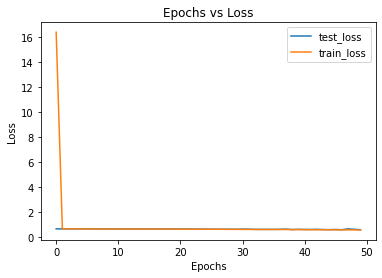

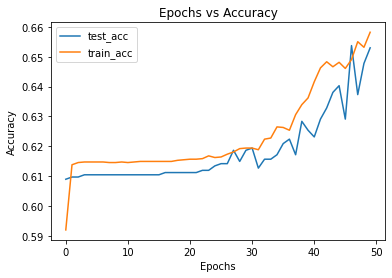

In [41]:
visualize_results(results_final)

In [43]:
train_predictions = model.predict(train_images)
test_predictions = model.predict(test_images)

In [45]:
train_predictions.shape

(5360, 1)

In [46]:
test_predictions

array([[0.8328992 ],
       [0.9277877 ],
       [0.6787948 ],
       ...,
       [0.95600134],
       [0.48049966],
       [0.6454785 ]], dtype=float32)

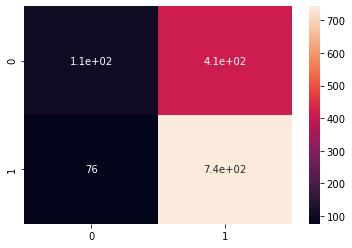

In [47]:

test_pred = (model3.predict(test_images) > 0.5).astype(int)
cf_matrix = confusion_matrix(test_labels, test_pred)
sns.heatmap(cf_matrix, annot=True);